## Screen Parsing

The purpose of this notebook is to experiment with the idea of using Canny edge detection along with
`knn` algorithms to devise a semantic hierarchy of screen elements that would enable users to match
on elements that are *text / subelement invariant*.
This is critical, for example, when looping over a list of buttons or dialogs that you would like to
match on, however the selection is based on relation to something in the overall hierarchy more than
it is based on the content or the appearance of the element itself.

In [1]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

As a principle example we can use this image of the Sectra PACS software for a future application
that involves clicking open reports and copy-pasting from them.

![Sectra Screen](data/sectra_reportlist.png)

This is a good use case for semantic parsing.
The clickable element is on the far right where the text inside the white button can either read
`No Score` or some text describing the score.
We can't match on the button itself because then we would have to enumerate all possible variants
of that button.
We also need some kind of state tracking to determine which buttons we hit and which we have not.

Find all text in the image and remove it

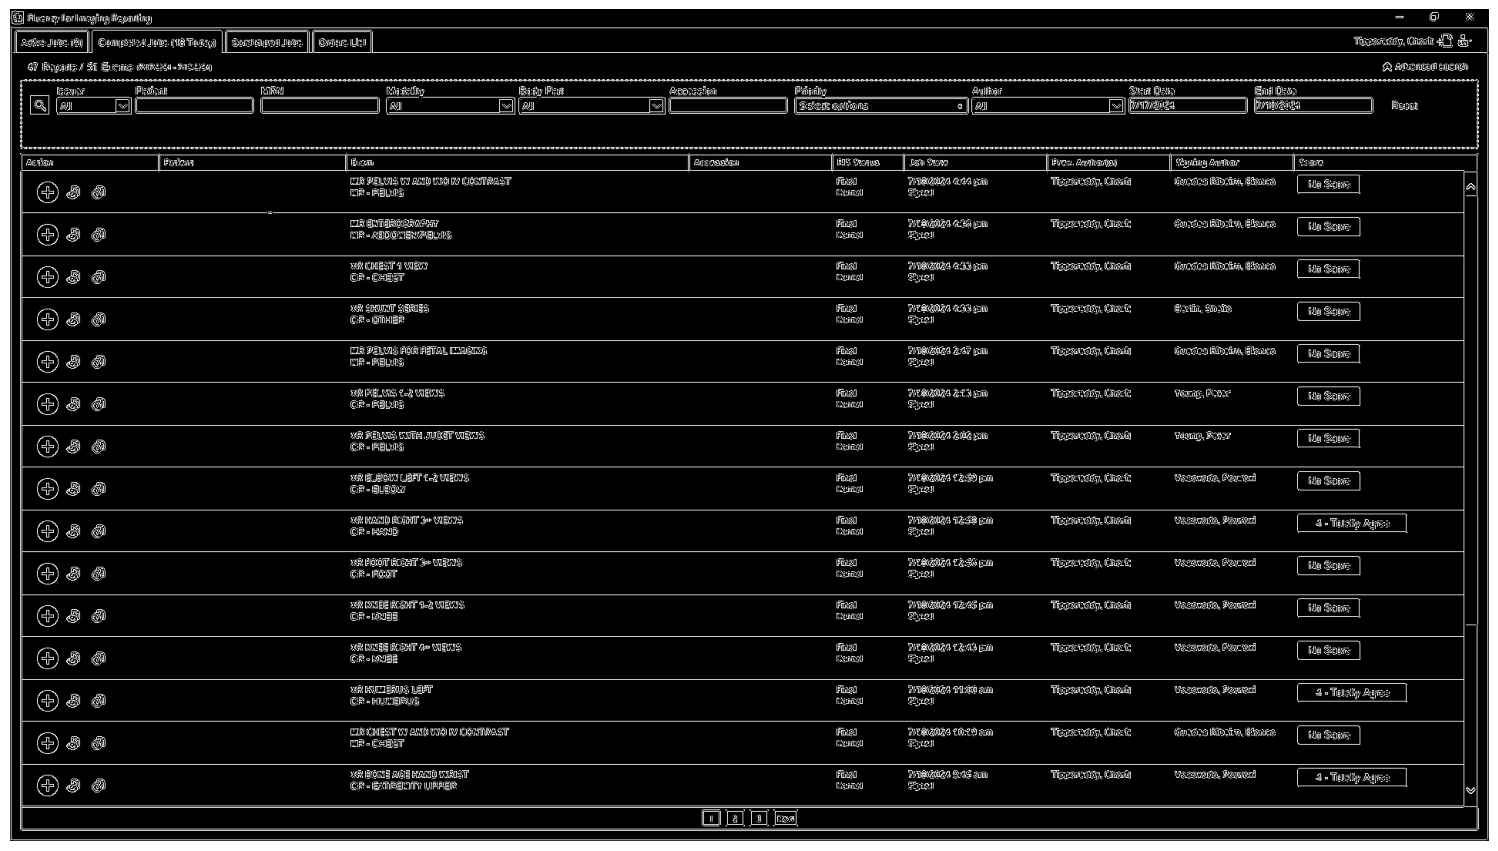

In [2]:
sectra = cv.imread("data/sectra_reportlist.png", cv.IMREAD_COLOR)
naive_edges = cv.Canny(sectra, 10, 100)
plt.figure(figsize=(1980/100, 1080/100))
plt.axis("off")
plt.imshow(naive_edges, cmap="gray")
plt.show()

### Parsing out Subregions (Rows)

Common problem: the rows parsed out using Canny share a common boundary so they can't be extracted
using connected components analysis

In [3]:
from math import ceil
def hough_to_cartesian(lines, img_shape):
    cartesian_lines = []
    for line in lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho

        x1 = ceil(x0 + img_shape[1] * np.round(-b, 3))
        y1 = ceil(y0 + img_shape[0] * np.round(a, 3))
        x2 = ceil(x0 - img_shape[1] * np.round(-b, 3))
        y2 = ceil(y0 - img_shape[0] * np.round(a, 3))

        cartesian_lines.append([(x1, y1), (x2, y2)])
    return cartesian_lines

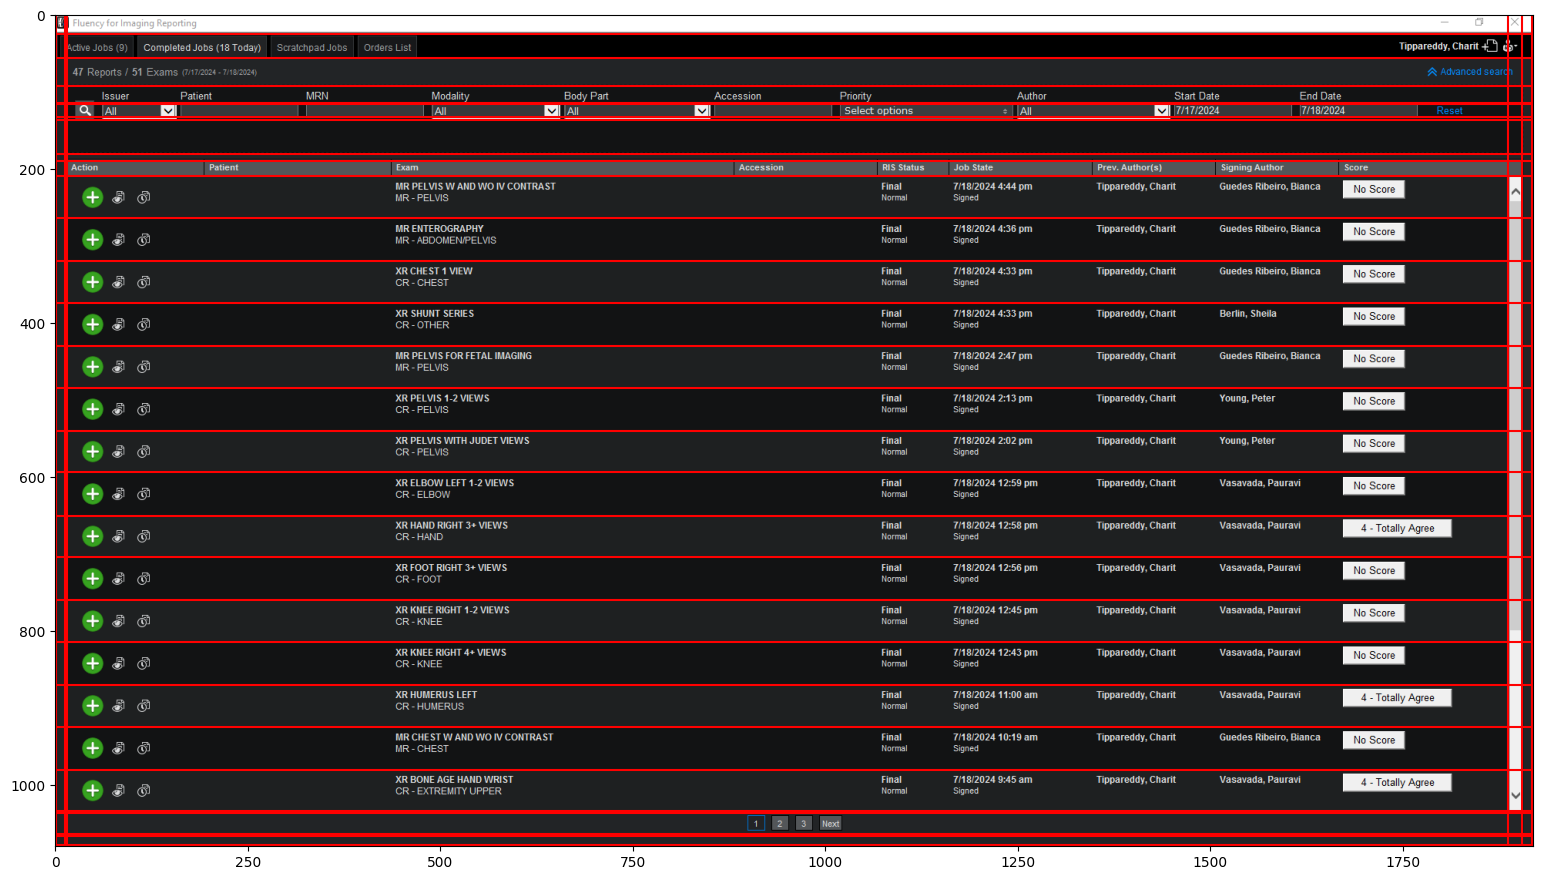

In [4]:
lines = cv.HoughLines(naive_edges, 1, np.pi / 180, 500)
cartesian_lines = hough_to_cartesian(lines, sectra.shape)

fig = plt.figure(figsize=(1980/100, 1080/100))
for line in cartesian_lines:
    x1, y1 = line[0]
    x2, y2 = line[1]
    plt.plot([x1, x2], [y1, y2], "r-")
    

plt.imshow(cv.cvtColor(sectra, cv.COLOR_BGR2RGB), cmap='gray')
plt.show()

Let's try it with another screen - this epic chart review screen - we select for specifically
the table part because that's what we would do in the actual UI when we provide it to the user.

![Epic Chart Review Table](data/epic_chart_review_table.png)

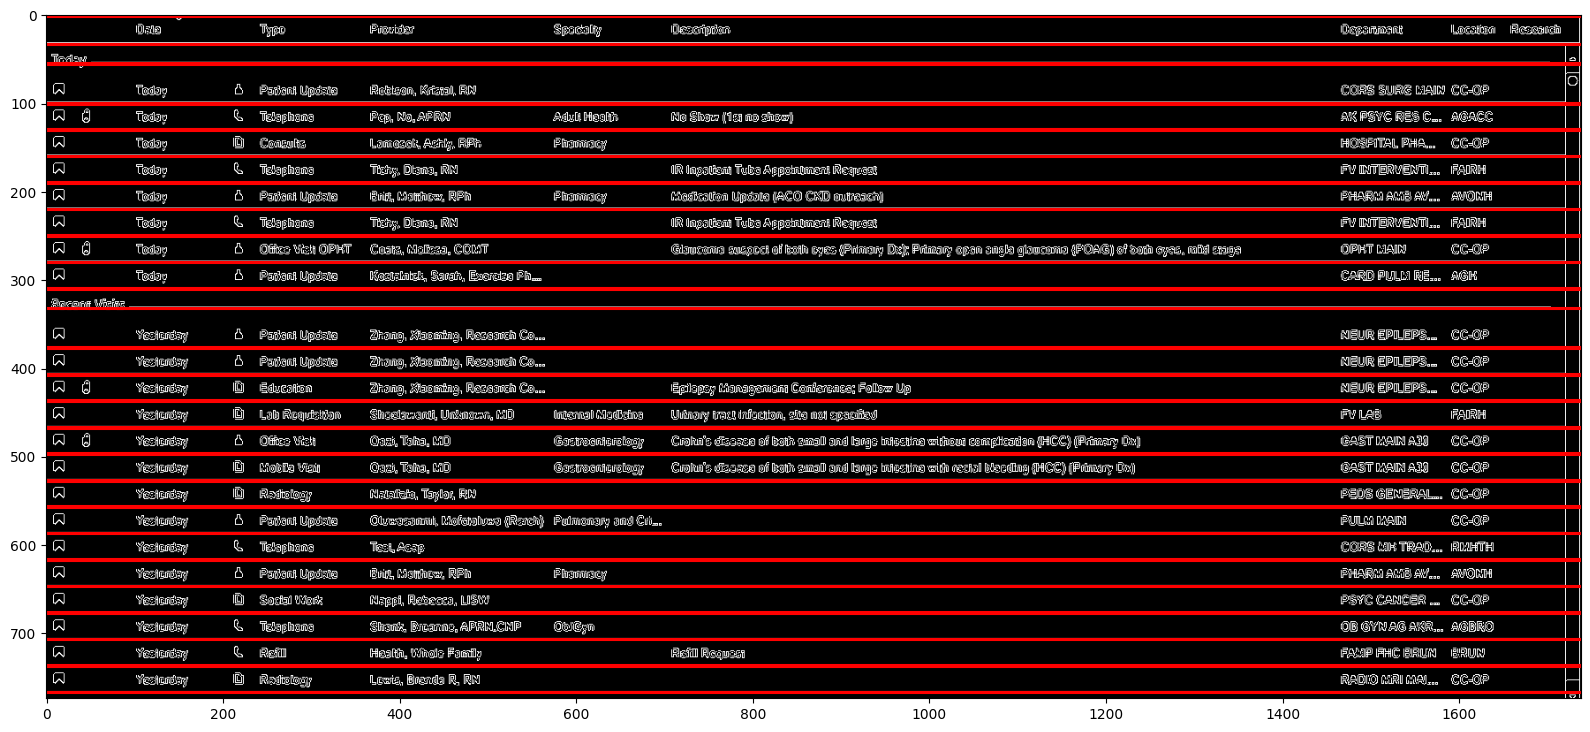

In [5]:
epic_chart_table = cv.imread("data/epic_chart_review_table.png", cv.IMREAD_COLOR)
epic_edges = cv.Canny(epic_chart_table, 10, 100)
epic_lines = cv.HoughLines(epic_edges, 1, np.pi / 180, 1500)

cartesian_lines = hough_to_cartesian(epic_lines, epic_chart_table.shape)

fig = plt.figure(figsize=(1980/100, 1080/100))
for line in cartesian_lines:
    x1, y1 = line[0]
    x2, y2 = line[1]
    plt.plot([x1, x2], [y1, y2], "r-")
    

plt.imshow(cv.cvtColor(epic_edges, cv.COLOR_BGR2RGB), cmap='gray')
plt.show()

Next Steps:
- Define region inside rectangle as a row
    - Need to filter out adjacent / touching lines because subsequent rows on the image are weird
    and alternate between being actual next rows and then just being a strange capture of half the
    - We can redefine the input requirements to be a bounding box surrounding the table and a bounding
    box around a single instance of a row - this defines the height and the other potential structure
    first row and then half the second.
- Define rows to attach to dataframe-like structure
- Map out how to use iterative scrolling to get the rest of the table structure

In [28]:
image_rows = []
sorted_lines = sorted([line for line in cartesian_lines if line[0][1] == line[1][1]], key=lambda x: x[0][1])
final_filtered_lines = []
MARGIN = (10, 50)  # defined by user input
for idx, line in enumerate(sorted_lines[:-1]): 
    next_line = sorted_lines[idx + 1]
    x1, y1 = line[0]
    x2, y2 = next_line[1]
    row_height = y2 - y1
    if row_height >= MARGIN[0] and row_height <= MARGIN[1]:
        image_rows.append(epic_chart_table[y1:y2, x1:x2])


In [29]:
len(image_rows)

25

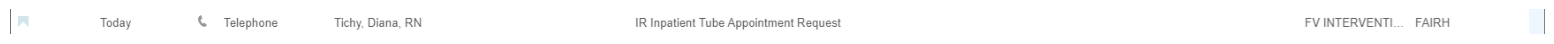

In [38]:
fig = plt.figure(figsize=(1980/100, 1080/100))
plt.axis("off")
plt.imshow(cv.cvtColor(image_rows[5], cv.COLOR_BGR2RGB))
plt.show()

We want to examine now whether running MSER on this row allows capture / definition of a "cell"

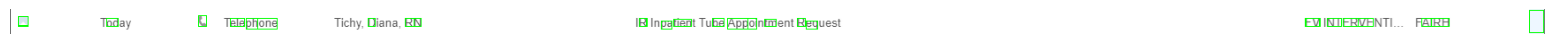

In [58]:
gray_again = cv.cvtColor(image_rows[5], cv.COLOR_BGR2GRAY)
mser = cv.MSER_create()
regions, _ = mser.detectRegions(gray_again)
for p in regions:
    xmax, ymax = np.amax(p, axis=0)
    xmin, ymin = np.amin(p, axis=0)
    cv.rectangle(image_rows[5], (xmin, ymin), (xmax, ymax), (0, 255, 0), 1)
    
plt.figure(figsize=(1980/100, 1080/100))
plt.axis("off")
plt.imshow(cv.cvtColor(image_rows[5], cv.COLOR_BGR2RGB))
plt.show()

Performance is fairly poor and unreliable - two options here:
- We can opt for another stage of user input that relies on using user drawn lines and columns in order to parse out what a table should be / look like
  - This is very tailored to clinical software as these will use one specific type of element, etc.
- We use custom detection methods like Hough transforms and so on to parse out the rows
  - The second step to define columns for each row relies on using Otsu thresholding to easily define foreground from background
- We use transformer models that can do table parsing

In [64]:
img_thresh

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

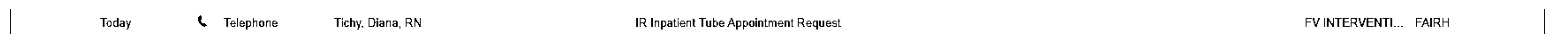

In [66]:
_, img_thresh = cv.threshold(gray_again, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
n_white_pix = np.sum(img_thresh == 255)
n_black_pix = np.sum(img_thresh == 0)

if n_white_pix < n_black_pix:
    img_thresh = cv.bitwise_not(img_thresh)

plt.figure(figsize=(1980/100, 1080/100))
plt.axis("off")
plt.imshow(img_thresh, cmap="gray")
plt.show()

This misses the bookmark column on the far left.
The key problem is that there is an iterative feedback system with drawing the boundaries and using
this thresholding system.
But if there is some kind of user review that needs to happen, then there must be a high cost
of the user doing all the labeling themselves anyway.
In this case, the cost doesn't seem high enough - we can modify the GUI so there are some nice QoL
changes where the user doesn't have to draw lines for every row and column - they can draw one 
and assume the rest are equally spaced.
Thus, for table definition and all other GUI elements going forward, we will rely on user manual
input where necessary and try to improve pain points through sophisticated automation and image 
analysis thereafter.

### Testing Extent of Template Matching

How general is template matching?
It would be ideal if it can successfully match certain tables / structures *invariant* of text content
where the top left corner of a previous table screengrab can still match even if the content of the
table dynamically changes.

(np.float64(-0.5), np.float64(1717.5), np.float64(752.5), np.float64(-0.5))

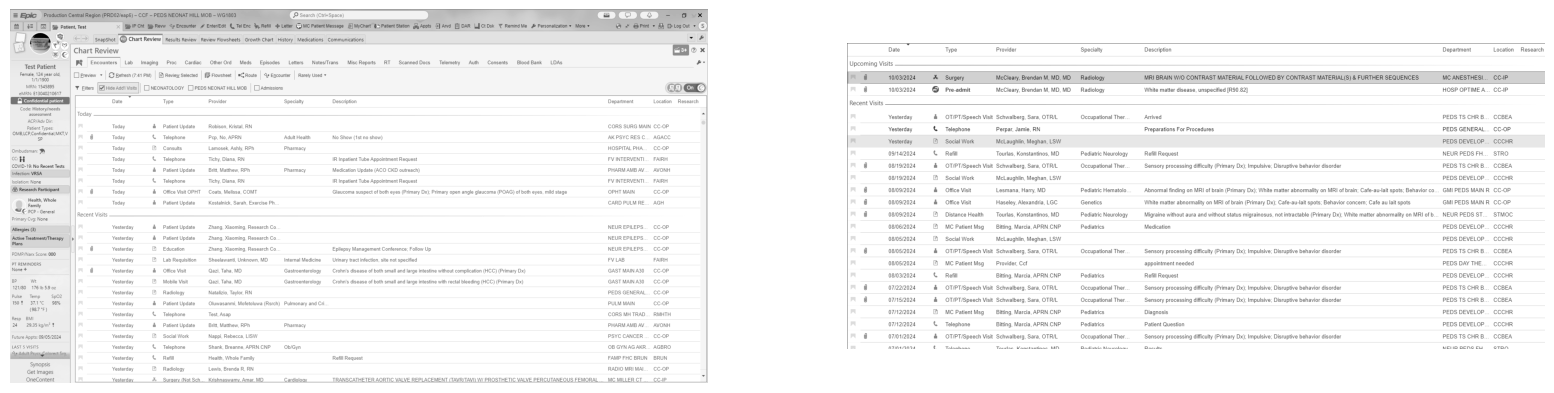

In [56]:
epic_screen = cv.imread("data/epic_chart_review_screen.png", cv.IMREAD_GRAYSCALE)
nonmatch_table = cv.imread("data/another_epic_chart_review_table.png", cv.IMREAD_GRAYSCALE)

fig, ax = plt.subplots(1, 2, figsize=(1980/100, 1080/100))

ax[0].imshow(epic_screen, cmap="gray")
ax[0].axis("off")
ax[1].imshow(nonmatch_table, cmap="gray")
ax[1].axis("off")

The rough structure of the table remains the same however the text populating it is very different.

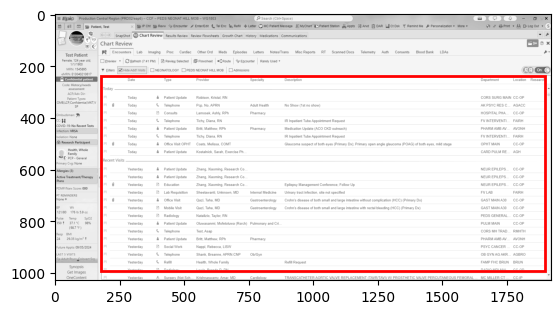

In [57]:
import matplotlib.patches as patches
res = cv.matchTemplate(epic_screen, nonmatch_table, cv.TM_CCOEFF_NORMED)
min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
cv.rectangle(epic_screen, max_loc, (max_loc[0] + nonmatch_table.shape[1], max_loc[1] + nonmatch_table.shape[0]), (255, 0, 0), 2)
fig, ax = plt.subplots(1)
ax.imshow(epic_screen, cmap="gray")
rect = patches.Rectangle(max_loc, nonmatch_table.shape[1], nonmatch_table.shape[0], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()

It is crazy that the match is actually fantastic!